In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
from datetime import datetime
import json

In [2]:
def create_lstm_model(units=50, optimizer='adam', batch_size=32, epochs=25):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer with 1 unit for predicting 'Close'
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [3]:
# Load Data
ticker_symbol = 'AAPL'
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2022, 1, 1)
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Prepare Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

prediction_days = 70

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, :])  # Using all four features
    y_train.append(scaled_data[x, 4])  # 'Close' is the fourth column (index 3)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Wrap the Keras model so it can be used by scikit-learn GridSearchCV
model = KerasRegressor(model=create_lstm_model, epochs=10, batch_size=32, verbose=1)  # Set verbose to 1 for more output

# Define the hyperparameter grid
param_grid = {
    'batch_size': [32],  
    'epochs': [25],  
    'optimizer': ['adam'], 
}

# Create Time Series Split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)


# Fit the grid search to the data
print("Starting grid search...")
grid_result = grid.fit(x_train, y_train)
print("Grid search completed!")

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Retrieve best hyperparameters
best_batch_size = grid_result.best_params_['batch_size']
best_optimizer = grid_result.best_params_['optimizer']
best_epochs = grid_result.best_params_['epochs']

# Build the final model with the best hyperparameters
print("Building final model with best hyperparameters...")
final_model = create_lstm_model(epochs=best_epochs, optimizer=best_optimizer, batch_size=best_batch_size)
final_model.fit(x_train, y_train)
print("Final model training completed!")

[*********************100%%**********************]  1 of 1 completed


Starting grid search...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Epoch 1/25
16/16 [==============================] - 3s 39ms/step - loss: 4.5312e-04
Epoch 2/25
16/16 [==============================] - 1s 37ms/step - loss: 1.1463e-04
Epoch 3/25
16/16 [==============================] - 1s 36ms/step - loss: 5.0236e-05
Epoch 4/25
16/16 [==============================] - 1s 36ms/step - loss: 3.6951e-05
Epoch 5/25
16/16 [==============================] - 1s 37ms/step - loss: 4.1783e-05
Epoch 6/25
16/16 [==============================] - 1s 38ms/step - loss: 3.3146e-05
Epoch 7/25
16/16 [==============================] - 1s 39ms/step - loss: 2.8932e-05
Epoch 8/25
16/16 [==============================] - 1s 38ms/step - loss: 2.7971e-05
Epoch 9/25
16/16 [==============================] - 1s 38ms/step - loss: 2.4785e-05
Epoch 10/25
16/16 [==============================] - 1s 39ms/step - loss: 2.7059e-05
Epoch 11/25
16/16 [==============================] - 1s 40ms/step - loss: 2.

In [6]:
# Update the end_date to today
end_date_today = dt.datetime.now()

# Retrieve data from the end_date until today
test_data = yf.download(ticker_symbol, start=end_date, end=end_date_today)

# Scale the test data using the same scaler
scaled_test_data = scaler.transform(test_data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

# Create sequences for the test set
x_test = []
y_test = []

# Use the same prediction_days value as in the training data
for x in range(prediction_days, len(scaled_test_data)):
    x_test.append(scaled_test_data[x - prediction_days:x, :])
    y_test.append(scaled_test_data[x, 4])  # 'Close' is the fifth column (index 4)

x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the test set to match the LSTM model's input shape
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


[*********************100%%**********************]  1 of 1 completed


In [7]:
# Predictions on the test set
y_pred = final_model.predict(x_test)

# Inverse transform the scaled predictions and true values to the original scale
y_pred_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_pred.reshape(-1, 1)), axis=1))[:, 4]
y_test_original = scaler.inverse_transform(np.concatenate((x_test[:, -1, :4], y_test.reshape(-1, 1)), axis=1))[:, 4]

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2) Score: {r2}")


15/15 [==============================] - 0s 10ms/step
Mean Absolute Error (MAE): 8.480373888991778
Mean Squared Error (MSE): 99.2571965988668
R-squared (R2) Score: 0.7296277592824512


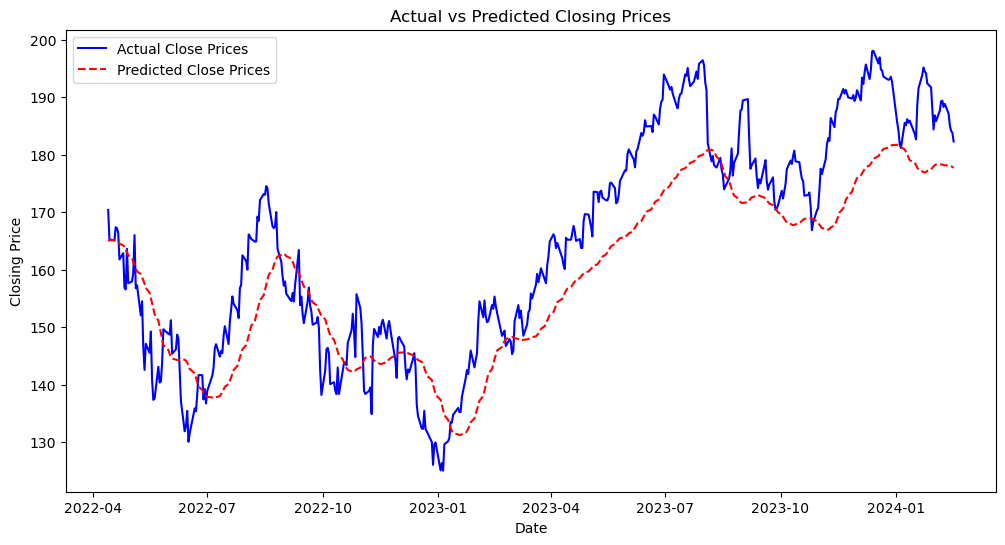

In [8]:
# Plot the actual vs predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[prediction_days:], y_test_original, label='Actual Close Prices', color='blue')
plt.plot(test_data.index[prediction_days:], y_pred_original, label='Predicted Close Prices', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()